# IMPORTANT

This notebook is still a WIP. The farther down you read, the less complete the code gets

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support

# Loading Data

In [2]:
data_df = pd.read_csv(Path('train.csv'))
training_data = pd.read_csv(Path('test.csv'))

In [3]:
data_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Feature Development & Transformation

## Cabin Letter

Cabin Letter seems to have an observable impact on survival, particularly in Cabin C and F. See pivot table Below. Running a Chi-Squared Test appears to back this as well.

In [4]:
data_df['CabinLetter'] = data_df['Cabin'].str[0]

In [5]:
cabin_letter_pivot = pd.pivot_table(
    data_df.groupby(
        ['CabinLetter', 'Survived'], as_index=False, dropna=False
    ).agg(COUNT=('PassengerId', 'count')),
    values='COUNT',
    index='CabinLetter',
    columns='Survived',
    dropna=False
).fillna(0)

cabin_letter_pivot / cabin_letter_pivot.sum()

Survived,0,1
CabinLetter,,
A,0.014572,0.020468
B,0.021858,0.102339
C,0.043716,0.102339
D,0.014572,0.073099
E,0.014572,0.070175
F,0.009107,0.023392
G,0.003643,0.005848
T,0.001821,0.000000
NaN,0.876138,0.602339


In [6]:
chi2_res = sp.stats.chi2_contingency(cabin_letter_pivot)

In [7]:
chi2_res.statistic, chi2_res.pvalue

(np.float64(99.16416061888009), np.float64(6.326020042314704e-18))

# Fare Transformation

There appears to be a relationship between Survival and fare, with the passengers with higher fares more likely to survive. However, the fare's distribution does not appear to be normally distributed judging by the figures below.

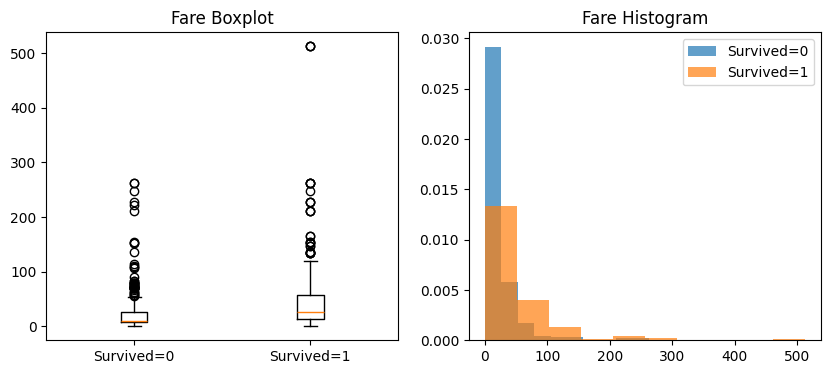

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.boxplot(
    (
        data_df.loc[data_df['Survived'] == 0, 'Fare'],
        data_df.loc[data_df['Survived'] == 1, 'Fare']
    ),
    tick_labels = ('Survived=0', 'Survived=1')
)
ax1.set_title('Fare Boxplot')

ax2.hist(
    data_df.loc[data_df['Survived'] == 0, 'Fare'],
    alpha=0.7,
    density=True
)
ax2.hist(
    data_df.loc[data_df['Survived'] == 1, 'Fare'],
    alpha=0.7,
    density=True
)
ax2.set_title('Fare Histogram')
ax2.legend(('Survived=0', 'Survived=1'))

plt.show()

Although not perfect, log transforming Fare (and leaving all 0 values as 0) will reduce the feature's measured variance and brings it's scale closer to other features. This will help with model stability and convergence.

In [9]:
fare_0_mask = data_df['Fare'] == 0
data_df['FareLog2'] = 0.0
data_df.loc[~fare_0_mask, 'FareLog2'] = np.log2(data_df.loc[~fare_0_mask, 'Fare'])

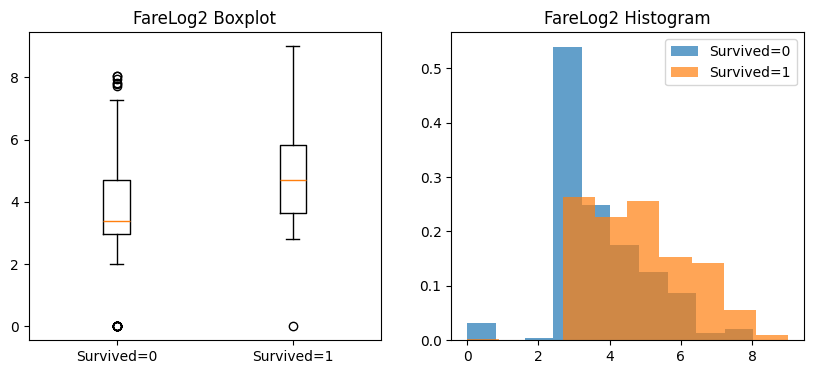

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.boxplot(
    (
        data_df.loc[data_df['Survived'] == 0, 'FareLog2'],
        data_df.loc[data_df['Survived'] == 1, 'FareLog2']
    ),
    tick_labels = ('Survived=0', 'Survived=1')
)
ax1.set_title('FareLog2 Boxplot')

ax2.hist(
    data_df.loc[data_df['Survived'] == 0, 'FareLog2'],
    alpha=0.7,
    density=True
)
ax2.hist(
    data_df.loc[data_df['Survived'] == 1, 'FareLog2'],
    alpha=0.7,
    density=True
)
ax2.set_title('FareLog2 Histogram')
ax2.legend(('Survived=0', 'Survived=1'))

plt.show()

In [11]:
def cat_expand(df, col_name):
    """
    utility function for expanding categorical fields
    """
    return pd.concat(
        (
            df, pd.get_dummies(df[col_name], prefix=col_name, dtype=int, dummy_na=True)
        ), axis = 1
    ).drop(columns=col_name)

Expanding categorical fields (CabinLetter, Embarked, Sex, and Pclass) to one-hot encodings

In [12]:
data_df['CabinLetter'] = data_df['Cabin'].str[0]
for col in ['CabinLetter', 'Embarked', 'Sex', 'Pclass']:
    data_df = cat_expand(data_df, col)

Adding a Fare scaled to the median to compare log transforming against simply scaling fare by the measured median.

In [13]:
median_fare = data_df['Fare'].median()
median_fare

np.float64(14.4542)

In [14]:
data_df['FareMed'] = data_df['Fare'] / 14.4542

## Age

With the exception of infants, toddlers, and young children, there does not appear to be a huge difference with age across the 2 classes.

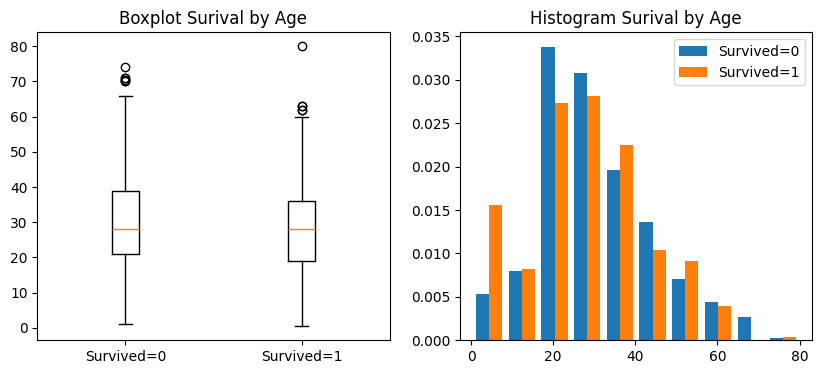

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.boxplot(
    (
        data_df.loc[(data_df['Survived'] == 0) & (~data_df['Age'].isna()), 'Age'],
        data_df.loc[(data_df['Survived'] == 1) & (~data_df['Age'].isna()), 'Age']
    ),
    tick_labels = ('Survived=0', 'Survived=1')
)
ax1.set_title('Boxplot Surival by Age')

ax2.hist(
    (
        data_df.loc[(data_df['Survived'] == 0) & (~data_df['Age'].isna()), 'Age'],
        data_df.loc[(data_df['Survived'] == 1) & (~data_df['Age'].isna()), 'Age']
    ),
    density=True,
)
ax2.legend(('Survived=0', 'Survived=1'))
ax2.set_title('Histogram Surival by Age')
plt.show()

Running an F-test shows a degree of signicance for age, but that group variance is mostly coming from the fact that most infants (Age between 0 and 1) in the sample survived. When controlling for infants, the group variance is not particularly significant.

In [16]:
sp.stats.f_oneway(
    data_df.loc[(data_df['Survived'] == 0) & (~data_df['Age'].isna()), 'Age'],
    data_df.loc[(data_df['Survived'] == 1) & (~data_df['Age'].isna()), 'Age']
)

F_onewayResult(statistic=np.float64(4.271194933815904), pvalue=np.float64(0.03912465401348333))

In [17]:
data_df['Infant'] = (data_df['Age'] <= 1).astype(int)

In [18]:
data_df.loc[data_df['Infant'] == 1, ['PassengerId', 'Name', 'Age', 'Infant', 'Survived']]

,PassengerId,Name,Age,Infant,Survived
78,79,"Caldwell, Master. Alden Gates",0.83,1,1
164,165,"Panula, Master. Eino Viljami",1.00,1,0
172,173,"Johnson, Miss. Eleanor Ileen",1.00,1,1
183,184,"Becker, Master. Richard F",1.00,1,1
305,306,"Allison, Master. Hudson Trevor",0.92,1,1
381,382,"Nakid, Miss. Maria (""Mary"")",1.00,1,1
386,387,"Goodwin, Master. Sidney Leonard",1.00,1,0
469,470,"Baclini, Miss. Helene Barbara",0.75,1,1
644,645,"Baclini, Miss. Eugenie",0.75,1,1
755,756,"Hamalainen, Master. Viljo",0.67,1,1


In [19]:
sp.stats.f_oneway(
    data_df.loc[
        (data_df['Survived'] == 0) \
            & (data_df['Infant'] != 1) \
            & (~data_df['Age'].isna()),
        'Age'
    ],
    data_df.loc[
        (data_df['Survived'] == 1) \
            & (data_df['Infant'] != 1) \
            & (~data_df['Age'].isna()),
        'Age'
    ]
)

F_onewayResult(statistic=np.float64(1.2919324381394264), pvalue=np.float64(0.2560822005263004))

To further complicate matters, about a 5th of the population is missing an Age.

In [20]:
sum(data_df['Age'].isna()) / data_df.shape[0]

0.19865319865319866

On its face, Age does not seem like the best feature to use. However, since we are training a deep learning algorithm. There may be more complex relationships with age and survival rate when factoring in things like sex, family members, etc.
<br><br>
Also, in an attempt to help the model infer more from what is observed in Age, we can also add a seperate binary feature that only acitvates when we don't know the age. The hope with this new feature is that when combined with other features, the model can infer more about the information about the passengers at the hidden layers.

In [21]:
data_df['AgeMissing'] = 0
data_df.loc[data_df['Age'].isna(), 'AgeMissing'] = 1

In [22]:
data_df.groupby('AgeMissing').agg(count=('PassengerId', 'count'), survival_rate=('Survived', 'mean'))

,count,survival_rate
AgeMissing,,
0,714,0.406162
1,177,0.293785


In [23]:
age_missing_pivot_table = pd.pivot_table(
    data_df.groupby(
        ['AgeMissing', 'Survived'],as_index=False
    ).agg(count=('PassengerId', 'count')),
    index='Survived',
    columns='AgeMissing',
    values='count'
)
age_missing_pivot_table

AgeMissing,0,1
Survived,,
0,424.0,125.0
1,290.0,52.0


In [24]:
sp.stats.chi2_contingency(age_missing_pivot_table)

Chi2ContingencyResult(statistic=np.float64(7.10597508442256), pvalue=np.float64(0.007682742096212262), dof=1, expected_freq=array([[439.93939394, 109.06060606],
       [274.06060606,  67.93939394]]))

Dividing Age by median age to help stabelize the gradient when training. This will also balance the age feature around 1, so filling in nulls with -1 will allow the model to observe a better distinction between ages that are missing and ages that are not.

In [25]:
data_df['Age'].median()

np.float64(28.0)

In [26]:
data_df['AgeMed'] = (data_df['Age'] / 28).fillna(-1)

<Axes: >

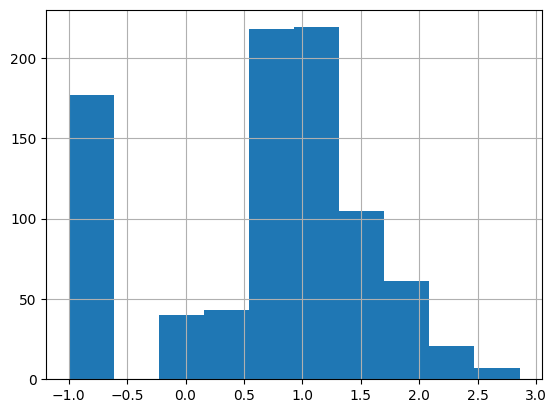

In [27]:
data_df['AgeMed'].hist()

# Dataset Preparation

### Streamlining Feature Engineering

Function for running feature engineering discussed in the above section.<br><br>
I've kept this method defined outside of the dataset function for data exploration and debugging purposes.

In [28]:
def titanic_feature_engineering(titanic_df):
    """
    Convenience function for processing all feature engineering.
    This helps me keep feature engineering consistent across testing
    and training datasets.
    """
    # copying original Data Frame to preserve its original format and 
    # representions
    fe_df = titanic_df.copy()

    # CabinLetter
    fe_df['CabinLetter'] = fe_df['Cabin'].str[0]

    # FareLog2
    fare_0_mask = fe_df['Fare'] == 0
    fe_df['FareLog2'] = 0.0
    fe_df.loc[~fare_0_mask, 'FareLog2'] = np.log2(
        fe_df.loc[~fare_0_mask, 'Fare']
    )

    # Fare Median
    fe_df['FareMed'] = fe_df['Fare'] / 14.4542

    # AgeMissing
    fe_df['AgeMissing'] = 0
    fe_df.loc[fe_df['Age'].isna(), 'AgeMissing'] = 1

    # AgeMed
    fe_df['AgeMed'] = (fe_df['Age'] / 28).fillna(-1)

    # Infant
    fe_df['Infant'] = (fe_df['Age'] <= 1).astype(int)
    
    # expanding categorical features to on-hot-encoded vectors
    for col in ['CabinLetter', 'Embarked', 'Sex', 'Pclass']:
        fe_df = pd.concat(
            (
                fe_df, pd.get_dummies(
                    fe_df[col], prefix=col, dtype=int, dummy_na=True
                )
            ), axis=1
        )

    return fe_df

### Defining Dataset Object for Titanic

Using PyTorch's builtin Dataset Objects. <br><br>
On the surface, all you need to know is that loading the Titanic data into these object strealines common operations like batch randomization, feature selection, model evaluation, etc.<br>
Feel free to take a closer look, but TitanicDataset and Dataloader are fundamantally convenience classes for managing the data.<br><br>
It's worth noting that I have an upsampling method in this class. Only 1/3 of the training population survived, so at training the model will show a bias towards non-survival with no upsampling.

In [59]:
class TitanicDataset(Dataset):
    X: torch.tensor
    y: torch.tensor
    
    def __init__(
        self, data, target_cols=['Survived'],
        feature_cols=[], device=torch.device('cpu')
    ):
        self.data = data
        self.device = device
        self.target_cols = target_cols
        self.feature_cols = feature_cols

        # define all meta data columns as all columns that are not
        # listed as target or feature data
        self.meta_cols = [
            col for col in self.data.columns
            if col not in self.target_cols + self.feature_cols
        ]

        self._set_X()
        self._set_y()

    def _set_X(self):
        self.X = torch.FloatTensor(
            self.data[self.feature_cols].to_numpy()
        ).to(self.device)

    def _set_y(self):
        self.y = torch.FloatTensor(
            pd.get_dummies(self.data['Survived']).to_numpy()
        ).to(self.device)

    def evaluate(self, model):
        """
        Convenience function for evaluating the model's performance.
        """
        y_pred = model(self.X).argmax(1)
        y_true = self.y.argmax(1)
        accuracy = (y_pred == y_true).sum() / len(y_true)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        return {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item()
        }

    def balance_target(self, random_state=None):
        """
        Helper function for balancing Survived and Non-Survived classes.
        If not invoked, training will show a bias towards Non-Survived class
        since only about 1/3 of the training data are in the survived class.
        """
        died_data = self.data[self.data['Survived'] == 0]
        survided_data = self.data[self.data['Survived'] == 1]
        survided_data = resample(
            survided_data, n_samples=died_data.shape[0], random_state=random_state
        )
        self.data = pd.concat((died_data, survided_data))
        self._set_X()
        self._set_y()
        
    def _swap_value(self, val, l1, l2):
        """
        internal function for swaping data between lists.
        """
        l1.append(l2.pop(l2.index(val)))
        return l1, l2

    def add_features(self, features):
        """
        Utility function for adding features from the columns labelled
        as meta-data
        """
        if isinstance(features, str):
            features = [features]
        for feature in features:
            if feature not in self.meta_cols + self.feature_cols:
                raise ValueError(f'{feature} not in Feature or Meta Data Columns')
            if feature in self.meta_cols:
                self.feature_cols, self.meta_cols = self._swap_value(
                    feature, self.feature_cols, self.meta_cols
                )
        self._set_X()

    def remove_features(self, features):
        """
        Utility function for removing columns from features and adding 
        them as meta-data
        """
        if isinstance(features, str):
            features = [features]
        for feature in features:
            if feature not in self.feature_cols:
                raise ValueError(f'{feature} not in Meta Data Columns')
            self.meta_cols, self.feature_cols = self._swap_value(
                feature, self.meta_cols, self.feature_cols
            )
        self._set_X()
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [49]:
fe_titanic_df = titanic_feature_engineering(
    pd.read_csv(Path('train.csv'))
)

In [50]:
fe_titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'CabinLetter',
       'FareLog2', 'FareMed', 'AgeMissing', 'AgeMed', 'Infant',
       'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
       'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_T',
       'CabinLetter_nan', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_nan', 'Sex_female', 'Sex_male', 'Sex_nan', 'Pclass_1.0',
       'Pclass_2.0', 'Pclass_3.0', 'Pclass_nan'],
      dtype='object')

In [51]:
seed_no = 250331

In [52]:
train_df, test_df = train_test_split(fe_titanic_df, train_size=0.8, random_state=seed_no)

# Modelling

*This section is still WIP. Still working on building out the prototype permutations.

In [36]:
def round_accuracies(metrics, r):
    """rounds accuracies of metrics for readability in the console"""
    ret = {}
    for metric, val in metrics.items():
        ret[metric] = round(val, r)
    return ret

In [37]:
def log_metrics(metrics_df, model_name, epoch, lr, loss, train_metrics=None, validation_metrics=None):
    """
    Helper function for tracking and comparing training runs.
    """
    record = {'model_name': model_name, 'learning_rate': lr, 'epoch': epoch, 'avg_loss': loss}
    if train_metrics:
        for key, val in train_metrics.items():
            record['train_'+key] = val
    if validation_metrics:
        for key, val in validation_metrics.items():
            record['validation_'+key] = val
    record = pd.DataFrame(pd.Series(record)).T
    metrics_df = pd.concat((metrics_df, record)).reset_index(drop=True)
    return metrics_df

In [69]:
# metrics table to store and compare runs
metrics_df = pd.DataFrame(columns=[
        'model_name', 'learning_rate', 'avg_loss', 'train_accuracy',
        'train_precision', 'train_recall', 'validation_accuracy', 
        'validation_precision', 'validation_recall'
    ]
)

In [56]:
device = torch.device('cpu')

In [57]:
torch.manual_seed(seed_no)

In [43]:
# baseline meta data columns; exclude features that either show little 
# promise in a standard linear model or require abstract transformations
# i.e. FareLog2
baseline = [
        'SibSp', 'Parch', 'FareMed', 'AgeMissing', 'Infant',
        'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
        'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_T',
        'CabinLetter_nan', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Embarked_nan', 'Sex_female', 'Sex_male', 'Sex_nan', 'Pclass_1.0',
        'Pclass_2.0', 'Pclass_3.0', 'Pclass_nan'
]
baseline_drop_nan = [
        'SibSp', 'Parch', 'FareMed', 'AgeMissing', 'Infant',
        'CabinLetter_A', 'CabinLetter_B', 'CabinLetter_C', 'CabinLetter_D',
        'CabinLetter_E', 'CabinLetter_F', 'CabinLetter_G', 'CabinLetter_T',
        'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Sex_female', 'Sex_male', 'Pclass_1.0',
        'Pclass_2.0', 'Pclass_3.0'
]
# same as baseline except replacing FareMed with FareLog2 
baseline_farelog2 = [
    'PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'Age', 
    'CabinLetter', 'Embarked', 'Sex', 'Pclass', 'FareMed', 'AgeMed'
]
# replace Infant and AgeMissing with AgeMed; the NN may be able to identify
# some non-linear relationships with entire age range
full_age = [
    'PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'Age', 
    'CabinLetter', 'Embarked', 'Sex', 'Pclass', 'FareLog2', 
    'AgeMissing', 'Infant'
]
fe_cols = baseline

In [60]:
train_dataset = TitanicDataset(
    train_df, 
    feature_cols=fe_cols,
    device=device
)
train_dataset.balance_target(random_state=seed_no)
test_dataset = TitanicDataset(
    test_df, 
    feature_cols=fe_cols,
    device=device
)

In [61]:
training_titanic_dataloader = DataLoader(train_dataset, batch_size=125, shuffle=True)

In [62]:
class TitanicNN(nn.Module):
    def __init__(self, input_w, width, depth):
        super().__init__()
        self.depth = depth
        self.width = width
        self.in_layer = nn.Linear(input_w, self.width)
        for i in range(self.depth):
            self.__setattr__(f'layer{i+1}', nn.Linear(self.width, self.width))
        self.out_layer = nn.Linear(self.width, 2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.in_layer(x)
        for i in range(self.depth):
            x = self.relu(self.__getattr__(f'layer{i+1}')(x))
        x = self.tanh(self.out_layer(x))
        return x

In [183]:
class TitanicDrouputNN(nn.Module):
    def __init__(self, input_w, width, depth, dropout=0.25):
        super().__init__()
        self.depth = depth
        self.width = width
        self.in_layer = nn.Linear(input_w, self.width)
        for i in range(self.depth):
            self.__setattr__(f'layer{i+1}', nn.Linear(self.width, self.width))
        self.out_layer = nn.Linear(self.width, 2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.in_layer(x)
        for i in range(self.depth):
            x = self.relu(self.__getattr__(f'layer{i+1}')(x))
            x = self.dropout(x)
        x = self.tanh(self.out_layer(x))
        return x

Cataloging various model permutations

In [416]:
models = {
    'baseline_27_0' : {'model': TitanicNN(25, 27, 0), 'columns': baseline},
    'baseline_27_1' : {'model': TitanicNN(25, 27, 1), 'columns': baseline},
    'baseline_27_2' : {'model': TitanicNN(25, 27, 2), 'columns': baseline},
    'baseline_54_2' : {'model': TitanicNN(25, 54, 2), 'columns': baseline},
    'baseline_108_2' : {'model': TitanicNN(25, 108, 2), 'columns': baseline},
    'baseline_108_3' : {'model': TitanicNN(25, 108, 3), 'columns': baseline},
    'baseline_108_4' : {'model': TitanicNN(25, 108, 4), 'columns': baseline},
    'baseline_27_4' : {'model': TitanicNN(25, 27, 4), 'columns': baseline},
    'baseline_37_3' : {'model': TitanicNN(25, 27, 4), 'columns': baseline},
    'baseline_108_2_dropout0.2' : {'model': TitanicDrouputNN(25, 108, 3, dropout=0.2), 'columns': baseline},
    'baseline_108_2_dropout0.3' : {'model': TitanicDrouputNN(25, 108, 3, dropout=0.3), 'columns': baseline},
    'baseline_27_3' : {'model': TitanicNN(25, 27, 3), 'columns': baseline},
    'baseline_54_3' : {'model': TitanicNN(25, 54, 3), 'columns': baseline},
    'baseline_54_3_dropout0.2' : {'model': TitanicDrouputNN(25, 54, 3, dropout=0.2), 'columns': baseline},
    'baseline_54_3_dropout0.25' : {'model': TitanicDrouputNN(25, 54, 3, dropout=0.25), 'columns': baseline},
    'baseline_54_3_dropout0.3' : {'model': TitanicDrouputNN(25, 54, 3, dropout=0.3), 'columns': baseline},
    'bsln_drop_na_27_0' : {'model': TitanicNN(25, 27, 0), 'columns': baseline_drop_nan},
    'bsln_drop_na_27_1' : {'model': TitanicNN(25, 27, 1), 'columns': baseline_drop_nan},
    'bsln_drop_na_27_2' : {'model': TitanicNN(25, 27, 2), 'columns': baseline_drop_nan},
    'bsln_drop_na_27_3' : {'model': TitanicNN(25, 27, 3), 'columns': baseline_drop_nan},
    # 'full_age_27_0' : {'model': TitanicNN(24, 27, 3), 'columns': full_age},
    # 'full_age_27_1' : {'model': TitanicNN(24, 27, 3), 'columns': full_age},
    # 'full_age_27_2' : {'model': TitanicNN(24, 27, 3), 'columns': full_age},
    # 'full_age_27_3' : {'model': TitanicNN(24, 27, 3), 'columns': full_age},
}

In [417]:
name = 'baseline_37_3'
model = models[name]['model']
model.to(device)

TitanicNN(
  (in_layer): Linear(in_features=25, out_features=27, bias=True)
  (layer1): Linear(in_features=27, out_features=27, bias=True)
  (layer2): Linear(in_features=27, out_features=27, bias=True)
  (layer3): Linear(in_features=27, out_features=27, bias=True)
  (layer4): Linear(in_features=27, out_features=27, bias=True)
  (out_layer): Linear(in_features=27, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [418]:
true_epoch = 0
name

'baseline_37_3'

In [432]:
lr = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=.9)

In [ ]:
train_df['']

In [433]:
epochs = 100
for e in range(epochs):
    epoch_losses = []
    for X, y in training_titanic_dataloader:
        pred = model.forward(X)
        loss = loss_fn(pred, y)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = sum(epoch_losses)/len(epoch_losses)
    if e % 20 == 0:
        true_epoch += e
        training_metrics = train_dataset.evaluate(model)
        validation_metrics = test_dataset.evaluate(model)
        metrics_df = log_metrics(
            metrics_df, name, true_epoch, lr, avg_loss,
            train_metrics=training_metrics, validation_metrics=validation_metrics
        )
        print(f'Loss: {round(avg_loss, 8)}   Train: {round_accuracies(training_metrics, 6)}   Test: {round_accuracies(validation_metrics, 6)}')

Loss: 0.3465679   Train: {'accuracy': 0.878161, 'precision': 0.9022, 'recall': 0.848276}   Test: {'accuracy': 0.810056, 'precision': 0.754098, 'recall': 0.707692}
Loss: 0.34639953   Train: {'accuracy': 0.87931, 'precision': 0.902439, 'recall': 0.850575}   Test: {'accuracy': 0.810056, 'precision': 0.754098, 'recall': 0.707692}
Loss: 0.34641988   Train: {'accuracy': 0.87931, 'precision': 0.904412, 'recall': 0.848276}   Test: {'accuracy': 0.810056, 'precision': 0.754098, 'recall': 0.707692}
Loss: 0.34606014   Train: {'accuracy': 0.87931, 'precision': 0.904412, 'recall': 0.848276}   Test: {'accuracy': 0.810056, 'precision': 0.754098, 'recall': 0.707692}
Loss: 0.34613234   Train: {'accuracy': 0.87931, 'precision': 0.904412, 'recall': 0.848276}   Test: {'accuracy': 0.810056, 'precision': 0.754098, 'recall': 0.707692}


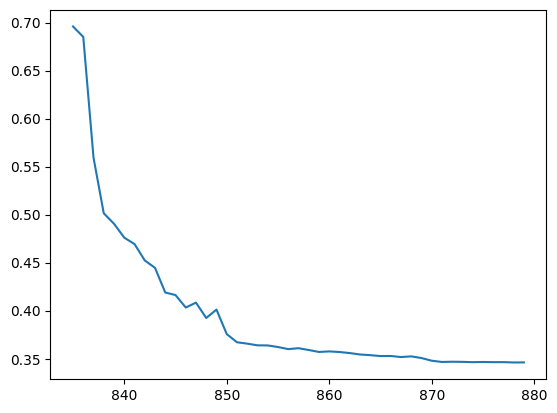

In [434]:
plt.plot(metrics_df.loc[metrics_df['model_name'] == name, 'avg_loss'])

In [435]:
metrics_df.groupby('model_name').agg({'avg_loss': 'min', 'validation_accuracy': 'max', 'train_accuracy': 'max'})

,avg_loss,validation_accuracy,train_accuracy
model_name,,,
baseline_108_2,0.3135,0.837989,0.895402
baseline_108_2_dropout0.2,0.347328,0.849162,0.883908
baseline_108_2_dropout0.3,0.380129,0.837989,0.865517
baseline_108_3,0.316028,0.826816,0.894253
baseline_108_4,0.305478,0.821229,0.901149
baseline_27_0,0.438186,0.787709,0.778161
baseline_27_1,0.414179,0.826816,0.831034
baseline_27_2,0.33148,0.837989,0.888506
baseline_27_3,0.329392,0.832402,0.889655


In [438]:
metrics_df.to_csv('model_permutations_250331.csv')

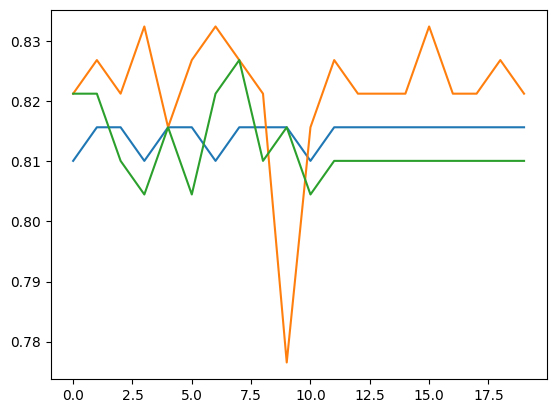

In [437]:
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_2'].tail(50).reset_index()['validation_accuracy'])
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_54_3'].tail(50).reset_index()['validation_accuracy'])
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_3'].tail(50).reset_index()['validation_accuracy'])
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_4'].tail(50).reset_index()['validation_accuracy'])
#plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_27_0'].tail(20).reset_index()['validation_accuracy'])
#plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_27_1'].tail(20).reset_index()['validation_accuracy'])
plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_27_2'].tail(20).reset_index()['validation_accuracy'])
plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_27_3'].tail(20).reset_index()['validation_accuracy'])
plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_37_3'].tail(20).reset_index()['validation_accuracy'])

#plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_2_dropout0.3'].tail(100).reset_index()['validation_accuracy'])
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_2'].tail(100)['validation_accuracy'])
# plt.plot(metrics_df[metrics_df['model_name'] == 'baseline_108_2'].tail(100)['validation_accuracy'])
plt.show()

In [236]:
metrics_df.sort_values('validation_accuracy', ascending=False).head(100).groupby('model_name').agg(count=('model_name', 'count'))

,count
model_name,
baseline_27_1,1
baseline_27_2,40
baseline_27_3,21
baseline_54_3,9
baseline_54_3_dropout0.2,11
baseline_54_3_dropout0.25,6
baseline_54_3_dropout0.3,12


In [516]:
yp = model(test_dataset.X).argmax(1)
yt = test_dataset.y.argmax(1)

In [127]:
precision_recall_fscore_support(yt, yp)

(array([0.89166667, 0.71186441]),
 array([0.86290323, 0.76363636]),
 array([0.87704918, 0.73684211]),
 array([124,  55]))

In [129]:
(yt == 0).sum()

tensor(124)

In [131]:
((yp == 1) & (yt == 1)).sum() / (((yp == 1) & (yt == 1)).sum() + ((yp == 0) & (yt == 1)).sum())

tensor(0.7636)

In [132]:
((yp == 1) & (yt == 1)).sum() / (((yp == 1) & (yt == 1)).sum() + ((yp == 1) & (yt == 0)).sum())

tensor(0.7119)

In [133]:
(yp == yt ).sum() / len(yp)

tensor(0.8324)